In [1]:
#!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


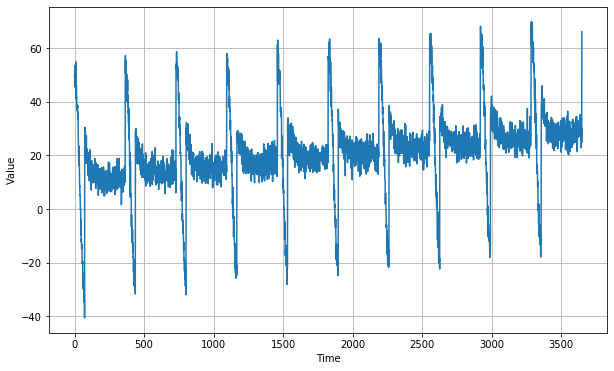

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.2,
                    np.cos(season_time * 5 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 8s 85ms/step - loss: 18.5045 - mae: 18.850218.1103 - mae: 18.609 - 8s 90ms/step - loss: 18.1347 - ma
Epoch 2/100
94/94 [==============================] - 3s 34ms/step - loss: 18.3283 - mae: 18.8281
Epoch 3/100
94/94 [==============================] - 3s 31ms/step - loss: 18.3375 - mae: 18.8028
Epoch 4/100
94/94 [==============================] - 2s 25ms/step - loss: 18.2623 - mae: 18.7745
Epoch 5/100
94/94 [==============================] - 3s 29ms/step - loss: 18.2969 - mae: 18.7424
Epoch 6/100
94/94 [==============================] - 3s 31ms/step - loss: 18.2028 - mae: 18.7059
Epoch 7/100
94/94 [==============================] - 3s 33ms/step - loss: 18.1691 - mae: 18.6645: 1s - 
Epoch 8/100
94/94 [==============================] - 3s 34ms/step - loss: 18.0960 - mae: 18.6177
Epoch 9/100
94/94 [==============================] - 3s 30ms/step - loss: 18.0538 - mae: 18.5650
Epoch 10/100
94/94 [==============================] - 3s 31ms/s

94/94 [==============================] - 3s 35ms/step - loss: 3.2936 - mae: 3.7854: 0s - loss: 3.3003 - 
Epoch 83/100
94/94 [==============================] - 3s 31ms/step - loss: 3.1116 - mae: 3.6008
Epoch 84/100
94/94 [==============================] - 3s 32ms/step - loss: 3.0633 - mae: 3.5254
Epoch 85/100
94/94 [==============================] - 3s 32ms/step - loss: 3.1227 - mae: 3.6091
Epoch 86/100
94/94 [==============================] - 3s 33ms/step - loss: 3.0832 - mae: 3.4333
Epoch 87/100
94/94 [==============================] - 3s 36ms/step - loss: 3.1079 - mae: 3.5800
Epoch 88/100
94/94 [==============================] - 3s 34ms/step - loss: 3.1631 - mae: 3.6299
Epoch 89/100
94/94 [==============================] - 3s 30ms/step - loss: 2.8839 - mae: 3.3659
Epoch 90/100
94/94 [==============================] - 3s 31ms/step - loss: 3.1021 - mae: 3.5555: 0s - loss: 3.0225 - 
Epoch 91/100
94/94 [==============================] - 3s 34ms/step - loss: 3.0387 - mae: 3.5040
Epoch 92/

[1e-08, 0.0001, 0, 30]

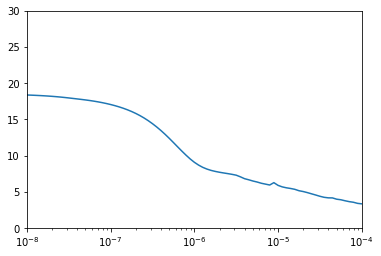

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 10.0)
])


model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=["mae"])

history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
94/94 [==============================] - 8s 88ms/step - loss: 7.9815 - mae: 8.3849
Epoch 2/500
94/94 [==============================] - 3s 31ms/step - loss: 5.8347 - mae: 6.3169
Epoch 3/500
94/94 [==============================] - 3s 32ms/step - loss: 4.9856 - mae: 5.3895
Epoch 4/500
94/94 [==============================] - 3s 33ms/step - loss: 4.4007 - mae: 4.8742: 1s - loss: 4.
Epoch 5/500
94/94 [==============================] - 3s 33ms/step - loss: 4.1273 - mae: 4.6171
Epoch 6/500
94/94 [==============================] - 3s 35ms/step - loss: 3.9813 - mae: 4.4664
Epoch 7/500
94/94 [==============================] - 3s 33ms/step - loss: 3.7946 - mae: 4.2728
Epoch 8/500
94/94 [==============================] - 3s 33ms/step - loss: 3.7153 - mae: 4.1888
Epoch 9/500
94/94 [==============================] - 3s 33ms/step - loss: 3.5159 - mae: 3.9854
Epoch 10/500
94/94 [==============================] - 3s 32ms/step - loss: 3.4270 - mae: 3.8692
Epoch 11/500
94/94 [==============

94/94 [==============================] - 3s 34ms/step - loss: 2.5177 - mae: 2.9926
Epoch 83/500
94/94 [==============================] - 3s 35ms/step - loss: 2.4904 - mae: 2.9654
Epoch 84/500
94/94 [==============================] - 3s 33ms/step - loss: 2.5382 - mae: 2.9894
Epoch 85/500
94/94 [==============================] - 2s 26ms/step - loss: 2.5441 - mae: 3.0159
Epoch 86/500
94/94 [==============================] - 3s 29ms/step - loss: 2.6175 - mae: 2.9717: 1s - loss
Epoch 87/500
94/94 [==============================] - 3s 27ms/step - loss: 2.5451 - mae: 3.0131
Epoch 88/500
94/94 [==============================] - 3s 28ms/step - loss: 2.5330 - mae: 2.9901
Epoch 89/500
94/94 [==============================] - 3s 32ms/step - loss: 2.5044 - mae: 2.9733
Epoch 90/500
94/94 [==============================] - 2s 26ms/step - loss: 2.5552 - mae: 3.0015
Epoch 91/500
94/94 [==============================] - 2s 26ms/step - loss: 2.5498 - mae: 3.0000
Epoch 92/500
94/94 [======================

94/94 [==============================] - 2s 24ms/step - loss: 2.5256 - mae: 2.8932
Epoch 166/500
94/94 [==============================] - 3s 27ms/step - loss: 2.4474 - mae: 2.9094
Epoch 167/500
94/94 [==============================] - 2s 26ms/step - loss: 2.4163 - mae: 2.8777
Epoch 168/500
94/94 [==============================] - 3s 32ms/step - loss: 2.4399 - mae: 2.9026
Epoch 169/500
94/94 [==============================] - 3s 36ms/step - loss: 2.4408 - mae: 2.8734
Epoch 170/500
94/94 [==============================] - 4s 43ms/step - loss: 2.4354 - mae: 2.9063
Epoch 171/500
94/94 [==============================] - 5s 50ms/step - loss: 2.4158 - mae: 2.8770
Epoch 172/500
94/94 [==============================] - 5s 48ms/step - loss: 2.4130 - mae: 2.8685
Epoch 173/500
94/94 [==============================] - 5s 48ms/step - loss: 2.4234 - mae: 2.8897
Epoch 174/500
94/94 [==============================] - 3s 32ms/step - loss: 2.4442 - mae: 2.9001
Epoch 175/500
94/94 [=======================

Epoch 247/500
94/94 [==============================] - 4s 44ms/step - loss: 2.3576 - mae: 2.8288
Epoch 248/500
94/94 [==============================] - 3s 32ms/step - loss: 2.3994 - mae: 2.8690
Epoch 249/500
94/94 [==============================] - 3s 30ms/step - loss: 2.3697 - mae: 2.8224
Epoch 250/500
94/94 [==============================] - 3s 28ms/step - loss: 2.3678 - mae: 2.8231
Epoch 251/500
94/94 [==============================] - 3s 28ms/step - loss: 2.3820 - mae: 2.8496: 0s - loss: 2.3618 - mae: 2.82
Epoch 252/500
94/94 [==============================] - 3s 28ms/step - loss: 2.3592 - mae: 2.8349
Epoch 253/500
94/94 [==============================] - 3s 28ms/step - loss: 2.3984 - mae: 2.8537: 1s - loss: 2.4012 - mae: - ETA: 1s - loss: 2
Epoch 254/500
94/94 [==============================] - 3s 32ms/step - loss: 2.4167 - mae: 2.8634
Epoch 255/500
94/94 [==============================] - 3s 32ms/step - loss: 2.3722 - mae: 2.8321
Epoch 256/500
94/94 [=============================

Epoch 329/500
94/94 [==============================] - 3s 34ms/step - loss: 2.3410 - mae: 2.8074
Epoch 330/500
94/94 [==============================] - 3s 29ms/step - loss: 2.3434 - mae: 2.7985
Epoch 331/500
94/94 [==============================] - 2s 26ms/step - loss: 2.3756 - mae: 2.8378
Epoch 332/500
94/94 [==============================] - 2s 26ms/step - loss: 2.3853 - mae: 2.8333
Epoch 333/500
94/94 [==============================] - 3s 29ms/step - loss: 2.3569 - mae: 2.8259
Epoch 334/500
94/94 [==============================] - 2s 26ms/step - loss: 2.3890 - mae: 2.8506
Epoch 335/500
94/94 [==============================] - 2s 26ms/step - loss: 2.3476 - mae: 2.8115
Epoch 336/500
94/94 [==============================] - 3s 31ms/step - loss: 2.3588 - mae: 2.8058
Epoch 337/500
94/94 [==============================] - 3s 33ms/step - loss: 2.3319 - mae: 2.8026
Epoch 338/500
94/94 [==============================] - 4s 42ms/step - loss: 2.3587 - mae: 2.8272
Epoch 339/500
94/94 [=========

Epoch 412/500
94/94 [==============================] - 4s 48ms/step - loss: 2.3321 - mae: 2.7990: 0s - loss: 2.3542 - ma
Epoch 413/500
94/94 [==============================] - 4s 47ms/step - loss: 2.3355 - mae: 2.7988: 1s - loss: 2.3
Epoch 414/500
94/94 [==============================] - 3s 31ms/step - loss: 2.3407 - mae: 2.8086: 2s
Epoch 415/500
94/94 [==============================] - 3s 35ms/step - loss: 2.3432 - mae: 2.7824
Epoch 416/500
94/94 [==============================] - 3s 36ms/step - loss: 2.3445 - mae: 2.7944
Epoch 417/500
94/94 [==============================] - 5s 49ms/step - loss: 2.4936 - mae: 2.8252
Epoch 418/500
94/94 [==============================] - 4s 38ms/step - loss: 2.3357 - mae: 2.7969
Epoch 419/500
94/94 [==============================] - 4s 39ms/step - loss: 2.3244 - mae: 2.7856
Epoch 420/500
94/94 [==============================] - 4s 47ms/step - loss: 2.3671 - mae: 2.8299
Epoch 421/500
94/94 [==============================] - 4s 44ms/step - loss: 2.3292 

94/94 [==============================] - 5s 52ms/step - loss: 2.3268 - mae: 2.8021
Epoch 494/500
94/94 [==============================] - 4s 41ms/step - loss: 2.3159 - mae: 2.7674
Epoch 495/500
94/94 [==============================] - 3s 37ms/step - loss: 2.3366 - mae: 2.8001
Epoch 496/500
94/94 [==============================] - 4s 38ms/step - loss: 2.3325 - mae: 2.7949
Epoch 497/500
94/94 [==============================] - 5s 55ms/step - loss: 2.3507 - mae: 2.7987
Epoch 498/500
94/94 [==============================] - 4s 44ms/step - loss: 2.3096 - mae: 2.7751
Epoch 499/500
94/94 [==============================] - 4s 46ms/step - loss: 2.3133 - mae: 2.7805
Epoch 500/500
94/94 [==============================] - 5s 50ms/step - loss: 2.3295 - mae: 2.7964


<Figure size 720x432 with 0 Axes>

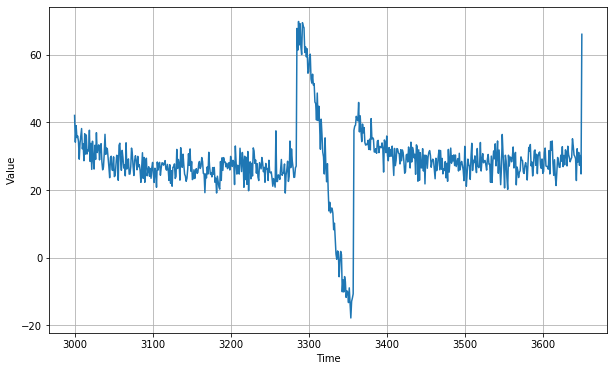

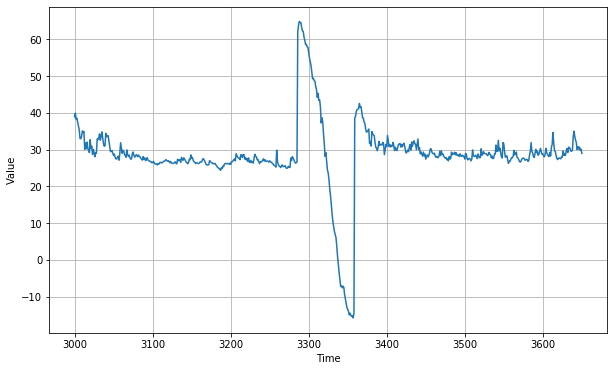

In [12]:
forecast = []
results = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]


<Figure size 720x432 with 0 Axes>

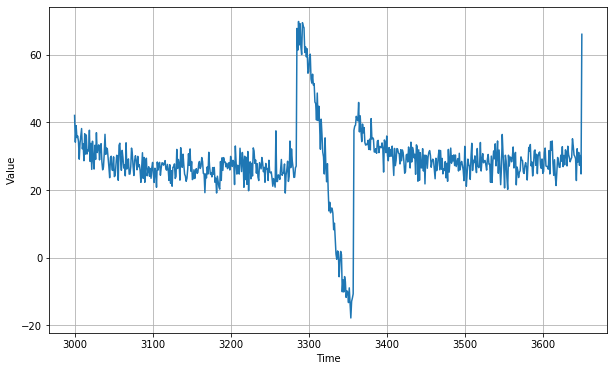

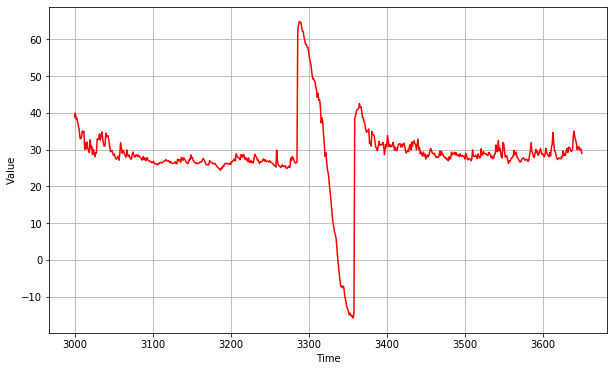

In [15]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results, 'r')

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.9411168

<Figure size 432x288 with 0 Axes>

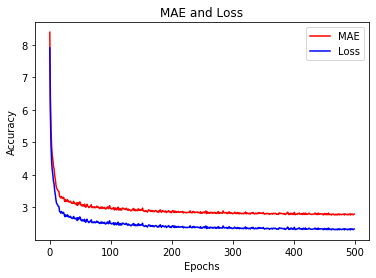

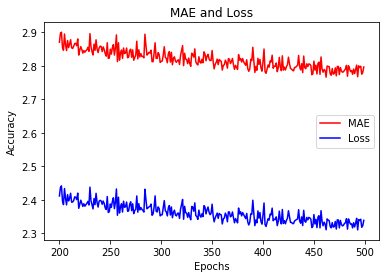

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()